In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
%matplotlib inline

In [3]:
pd.to

# Importing and Transforming Data

In [32]:
data = pd.read_csv("/home/grobleke/OTB_small.csv")
data.turn_color = data.turn_color.astype("category")
data.piece_moved = data.piece_moved.astype("category")
data.captured_piece = data.captured_piece.astype("category")
data.promotion_piece = data.promotion_piece.astype("category")
data.check_state = data.check_state.astype("category")
data.castle_side = data.castle_side.astype("category")
data.head()

,game_id,turn_color,turn_number,piece_moved,source_col,source_row,dest_col,dest_row,captured_piece,promotion_piece,check_state,castle_side
0,1,w,1,P,4,1,4,3,NaN,NaN,NaN,NaN
1,1,b,2,p,3,6,3,4,NaN,NaN,NaN,NaN
2,1,w,3,P,4,3,3,4,p,NaN,NaN,NaN
3,1,b,4,q,3,7,3,4,P,NaN,NaN,NaN
4,1,w,5,N,1,0,2,2,NaN,NaN,NaN,NaN


# Average Turns per Game

In [39]:
turns_per_game = data.groupby("game_id")["turn_number"].max()

In [40]:
turns_per_game.values.mean()

67.520270270270274

# Death Map

Unsuprisingly, the center of the map is where the action takes place.

In [88]:
death_map = data.groupby(["dest_row", "dest_col"])["captured_piece"].count()
death_map = pd.DataFrame(death_map)
death_map.columns = ["death_toll"]
death_map = death_map.reset_index().pivot_table(index="dest_row", columns="dest_col")

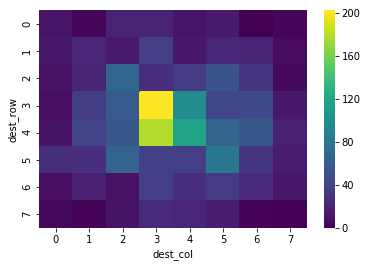

In [92]:
sns.heatmap(death_map["death_toll"], cmap="viridis")

# Promotion Selection

Unsuprisingly, there are only 7 promotions among the first 152 games and, of those 7, the promotion has always been to a queen.

In [44]:
data.promotion_piece.value_counts()

queen    7
Name: promotion_piece, dtype: int64

# Castle Side comparison

In [93]:
data.castle_side.value_counts()

k    221
q     20
Name: castle_side, dtype: int64

# Queen Advantage

If we define a queen advantage to be the number of turns between the two queen's death or the one of the queen's death and the end of the game. In general, the advantage is typically short lived. On average, the advantage last for about 4 turns; however, it is frequently the case that the queens are traded one after another. That is the queen advantage only last for one turn in most games.

In [208]:
# Get all turns where the queen of one of the players were captured.
queen_captured = data[data.captured_piece.isin(["q", "Q"])]
queen_captured.head()

# Get the difference between the max and min for turns where the queen of one of the players were lost.
queen_alive_max = pd.DataFrame(queen_captured.groupby("game_id")["turn_number"].max())
queen_alive_min = pd.DataFrame(queen_captured.groupby("game_id")["turn_number"].min())
queen_advantage = queen_alive_max - queen_alive_min

# If there is a zero, it is due to where one of the queens remained alive the entire game (min == max)
# We will backfill the data by getting the game_ids where there were an advantage of 0, get the max turn number,
# get the difference between when the first queen was lost with the turn number, and merging it back with the queen
# array.
zero_advantage = queen_advantage[queen_advantage.turn_number == 0].reset_index().game_id.values
games_with_zero_advantage = data[data.game_id.isin(zero_advantage)]
max_turns_zero_advantage = pd.DataFrame(games_with_zero_advantage.groupby("game_id")["turn_number"].max())
max_turns_zero_advantage = (max_turns_zero_advantage - queen_alive_min).dropna()
queen_advantage = pd.merge(queen_advantage, max_turns_zero_advantage, how="left", left_index=True, right_index=True)
queen_advantage = pd.DataFrame(queen_advantage.turn_number_y.fillna(queen_advantage.turn_number_x))
queen_advantage.columns = ["advantage"]
print("mean {0}, median {1} mode {2}".format(queen_advantage.mean().values,
                                             queen_advantage.median().values,
                                             queen_advantage.mode().values))

mean [ 4.04166667], median [ 1.] mode [[ 1.]]


# Number of checks per game

In [216]:
data[data.check_state == "+"].groupby("game_id")["turn_number"].count().mean()

5.2407407407407405

# First Turn Advantage

It seems that first turn advantage seems insignificant. We could do an association rule on this and check for lift and etc.

In [229]:
last_turn_per_game = pd.DataFrame(data.groupby("game_id")["turn_number"].max())
last_turn_per_game = last_turn_per_game.reset_index()

In [233]:
final_move_per_game = pd.merge(last_turn_per_game, data[data.check_state == "+"],
                               how="inner", on=["game_id", "turn_number"])
final_move_per_game["turn_color"].value_counts()

b    16
w    12
Name: turn_color, dtype: int64